**Dependencies**

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
import sys
import pdb

sys.path.append('/home/deveringham/thesis/rcwa_tf/src/')
import rcwa_utils
import tensor_utils
import solver
import solver_metasurface
import tf_utils

**Configure Devices and Measure GPU Memory Usage**

In [2]:
# Limit GPU memory growth
tf_utils.config_gpu_memory_usage()

# Choose the device to run on
use_gpu = True
tfDevice = '/job:localhost/replica:0/task:0/device:GPU:1' if use_gpu else '/CPU:0'
print('Executing on device ' + tfDevice + ' ...')

gpu_memory_init = tf_utils.gpu_memory_info()

 
Physical devices cannot be modified after being initialized
Executing on device /job:localhost/replica:0/task:0/device:GPU:1 ...


**Loss Function Definition**

In [3]:
def focal_spot(params):

    # Generate permittivity and permeability distributions.
    ER_t, UR_t = solver_metasurface.generate_copilot_metasurface_singlelayer(z_var, params)

    # Simulate the system.
    outputs = solver.simulate(ER_t, UR_t, params)

    # First loss term: maximize sum of electric field magnitude within some radius of the desired focal point.
    r = params['focal_spot_radius']
    field = outputs['ty'][:, :, :, np.prod(params['PQ']) // 2, 0]
    focal_plane = solver.propagate(params['input'] * field, params['propagator'], params['upsample'])
    index = (params['pixelsX'] * params['upsample']) // 2
    l1 = tf.math.reduce_sum(tf.abs(focal_plane[0, index-r:index+r, index-r:index+r]))

    # Second loss term: minimize sum of electric field magnitude elsewhere.
    l2 = tf.math.reduce_sum(tf.abs(focal_plane[0, :, :])) - l1

    # First regularization term.
    # Penalize values in z which are far from 1 or params['erd'].
    r1 = tf.math.reduce_sum( 
        (z_var - 1) * (z_var - 1) * (z_var - params['erd']) * (z_var - params['erd']) ).numpy()

    # Final loss: (negative) field intensity at focal point + regularization term.
    return -params['w_l1']*l1 + params['w_l2']*l2 + params['w_r1']*r1

**Initialize Parameters**

In [4]:
with tf.device(tfDevice):
    
    # Source parameters.
    wavelengths = [632.0]
    thetas = [0.0]
    phis = [0.0]
    pte = [1.0]
    ptm = [0.0]
    
    # Device parmeters.
    pixelsX = 25
    pixelsY = pixelsX
    erd = 6.76
    ers = 2.25
    eps_min = 1.0
    eps_max = erd
    L = [632.0, 632.0]
    Nlay = len(L)
    Lx = 0.7 * 632.0
    Ly = Lx
    
    # Solver parameters.
    PQ = [5,5]
    Nx = 16
    Ny = Nx
    upsample = 11
    
    # Problem parameters.
    N = 100
    w_l1 = 1.0
    w_l2 = 0.0
    w_r1 = 0.0
    thresholding_enabled = True
    sigmoid_coeff = 1.0
    sigmoid_update = 20.0 / N
    learning_rate = 1E-0
    focal_spot_radius = 10
    random_init = False
    debug = False
    
    
    # Initialize and populate dictionary of parameters.
    params = solver.initialize_params(wavelengths=wavelengths, thetas=thetas, phis=phis,
                                      pte=pte, ptm=ptm,
                                      pixelsX=pixelsX, pixelsY=pixelsY,
                                      erd=erd, ers=ers, PQ=PQ,
                                      Lx=Lx, Ly=Ly,
                                      L=L, Nx=Nx,
                                      eps_min=eps_min, eps_max=eps_max)
    
    params['N'] = N
    params['w_l1'] = w_l1
    params['w_l2'] = w_l2
    params['w_r1'] = w_r1
    params['thresholding_enabled'] = thresholding_enabled
    params['sigmoid_coeff'] = sigmoid_coeff
    params['sigmoid_update'] = sigmoid_update
    params['learning_rate'] = learning_rate
    params['focal_spot_radius'] = focal_spot_radius
    params['random_init'] = random_init
    params['debug'] = debug

    # Define the free-space propagator and input field distribution for the metasurface.
    params['f'] = 1.0 * params['Lx'] * params['pixelsX']
    params['upsample'] = upsample
    params['propagator'] = solver.make_propagator(params, params['f'])
    params['input'] = solver.define_input_fields(params)
    
    # Get initial permittivity and permeability profile for the metasurface.
    z_initial = solver_metasurface.init_copilot_metasurface(params)
    z_var = tf.Variable(z_initial, dtype=tf.float32)

**Optimize**

In [5]:
with tf.device(tfDevice):

    # Define an optimizer and data to be stored.
    opt = tf.keras.optimizers.Adam(learning_rate=params['learning_rate'])
    loss = np.zeros(params['N'] + 1)

    # Optimize.
    print('\nOptimizing... Iteration ', end="")
    
    i = 0
    #stopping_condition = 0.00001
    while i < params['N']:
        print(str(i) + ', ', end="")
        
        # Original version, replaced with calls to tape.gradient() and opt.apply_gradients()
        #opt.minimize(focal_spot, var_list = [z_var])
        
        # Calculate gradients.
        with tf.GradientTape() as tape:
            l = focal_spot(params)
            grads = tape.gradient(l, [z_var])
        
        # Apply gradients to variables.
        opt.apply_gradients(zip(grads, [z_var]))
        
        loss[i] = l.numpy()
        
        # Anneal sigmoid coefficient.
        params['sigmoid_coeff'] += params['sigmoid_update']
        
        # Check convergence condition.
        #if (i > 0) and (tf.math.abs((loss[i]/loss[i-1])-1) < stopping_condition):
        #    break
            
        # Increment loop counter.
        i += 1
    
    if (i == N): print('maximum iterations reached.')
    else: print('stopping condition fulfilled.')
        
    # Final sigmoid pass.
    if params['thresholding_enabled']:
        z_var = tf.math.sigmoid(params['sigmoid_coeff'] * (z_var - (1 + (params['erd']-1)/2)) )
        z_var = 1 + (params['erd'] - 1) * z_var
    
    # Final range clip.
    z_var = tf.clip_by_value(z_var, clip_value_min = params['eps_min'], clip_value_max = params['eps_max'])
    
    # Get final loss.
    loss[i] = focal_spot(params).numpy()
    print('Final Loss: ' + str(loss[i]))


Optimizing... Iteration 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, maximum iterations reached.
Final Loss: -1064.606689453125


**Display Learning Curve**

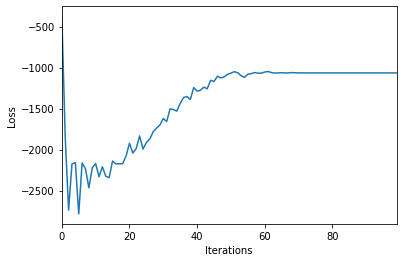

In [6]:
with tf.device(tfDevice):
    
    plt.plot(loss[:i])
    plt.xlabel('Iterations')
    plt.ylabel('Loss')
    plt.xlim(0, i-1)
    plt.show()

**Display Resulting Intensity on the Focal Plane**

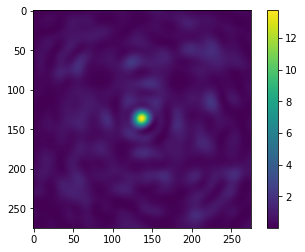

In [7]:
with tf.device(tfDevice):
    
    ER_t, UR_t = solver_metasurface.pixel_to_stacked(z_var, params)
    outputs = solver.simulate(ER_t, UR_t, params)
    field = outputs['ty'][:, :, :, np.prod(params['PQ']) // 2, 0]
    focal_plane = solver.propagate(params['input'] * field, params['propagator'], params['upsample'])
    plt.imshow(tf.abs(focal_plane[0, :, :]) ** 2)
    plt.colorbar()

***Display Resulting Metasurface***

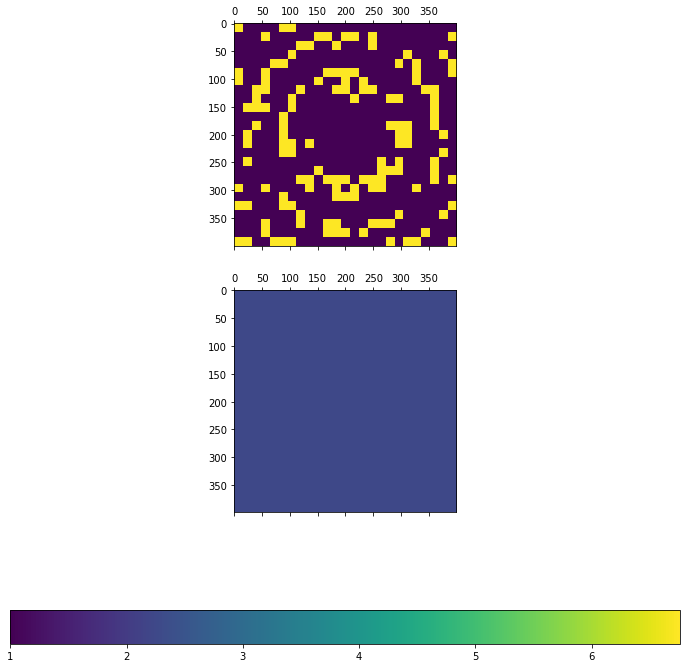

In [8]:
with tf.device(tfDevice):
    
    solver_metasurface.display_metasurface(ER_t, params)

***Check Memory Utilization***

In [9]:
gpu_memory_final = tf_utils.gpu_memory_info()
gpu_memory_used = [gpu_memory_final[1][0] - gpu_memory_init[1][0], gpu_memory_final[1][1] - gpu_memory_init[1][1]]
print('Memory used on each GPU(MiB): ' + str(gpu_memory_used))

Memory used on each GPU(MiB): [9374, 0]
